In [ ]:
from fusion import compute_bdi, compute_ec,compute_st, process_vibration, process_ae, process_triaxial_vib

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 
import scipy
import os
import glob
import seaborn as sns
import itertools
import gc
import time
import scienceplots
import sys
import librosa
from nptdms import TdmsFile
from scipy import stats
from natsort import natsorted

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.ticker import FormatStrFormatter
import matplotlib as mpl
import seaborn as sns
from scipy.stats import norm
from scipy.interpolate import interp1d
from scipy.interpolate import make_interp_spline, BSpline

sys.path.append('../utils/')
from utils.preprocessing import centimeter,one_column,two_column,cm_std,cm_bright,cm_highCon,cm_mark
np.random.seed(16)
matplotlib.rcParams['text.usetex'] = True
plt.rcParams["text.usetex"] = True
matplotlib.rcParams['figure.dpi'] = 300
plt.style.use(['science','nature'])
plt.rcParams['figure.constrained_layout.use'] = True
mpl.rcParams.update(one_column)

import sys
sys.path.append('./utils')
# from pydub import AudioSegment
import itertools
import string
import glob
import subprocess
import seedir
from utils.preprocessing import print_tdms_structure,check_identical_csv_lengths
from utils.preprocessing import linearSpectrogram, logMelSpectrogram,melSpectrogram, logSpectrogram, standardize_array,slice_indices
from tqdm import tqdm

from MyDataset import sampling_rate_ae,sampling_rate_vib, project_dir, project_name, data_dir, dataDir_ae, dataDir_vib, alphabet

In [2]:
df = pd.read_excel(os.path.join(project_dir,"parameters.xlsx"),index_col=0)
df.columns = ["Surface speed","Workpiece rotation speed","Grinding depth"]
df["Surface speed"] = df["Surface speed"].str.extract(r'(\d+)').astype(float) # mm/s
df["Workpiece rotation speed"] = df["Workpiece rotation speed"].str.extract(r'(\d+)').astype(float) # rpm
df["Grinding depth"] = df["Grinding depth"].str.extract(r'(\d+)').astype(float) # um
parameters = df.copy()
del df

df = pd.read_csv(os.path.join(project_dir,"surface roughness.csv"),index_col=None)
df.columns=["Surface roughness"]
sr = df.iloc[:,0].to_numpy()
parameters

,Surface speed,Workpiece rotation speed,Grinding depth
No.,,,
1,25.0,20.0,20.0
2,25.0,40.0,30.0
3,25.0,60.0,40.0
4,25.0,80.0,50.0
5,30.0,40.0,40.0
6,30.0,60.0,50.0
7,30.0,80.0,20.0
8,30.0,20.0,30.0
9,35.0,60.0,50.0


In [3]:
n_fft = 512
hop_length = n_fft//8
window_type = 'hann'
mel_bins=256

n_fft_vib = 512

spec_ae_list = []
spec_vib_list = []
wavelet_energy_narrow_list = []
wavelet_energy_broad_list  = []
burst_rate_narrow_list = []
burst_rate_broad_list  = []
ec_list = []
bid_list = []
st_list = []
env_kurtosis_list_x = []
env_kurtosis_list_y = []
env_kurtosis_list_z = []
mag_list = []

In [4]:
ae_names = natsorted([os.path.join(dataDir_ae,i) for i in os.listdir(dataDir_ae) if os.path.splitext(i)[1] == '.txt'])
ae_names

['C:\\Users\\Public\\Documents\\Data\\Grinding\\XiAnJiaoTong\\AE\\1-01-0.txt',
 'C:\\Users\\Public\\Documents\\Data\\Grinding\\XiAnJiaoTong\\AE\\1-02-0.txt',
 'C:\\Users\\Public\\Documents\\Data\\Grinding\\XiAnJiaoTong\\AE\\1-03-0.txt',
 'C:\\Users\\Public\\Documents\\Data\\Grinding\\XiAnJiaoTong\\AE\\1-04-0.txt',
 'C:\\Users\\Public\\Documents\\Data\\Grinding\\XiAnJiaoTong\\AE\\1-05-0.txt',
 'C:\\Users\\Public\\Documents\\Data\\Grinding\\XiAnJiaoTong\\AE\\1-06-0.txt',
 'C:\\Users\\Public\\Documents\\Data\\Grinding\\XiAnJiaoTong\\AE\\1-07-0.txt',
 'C:\\Users\\Public\\Documents\\Data\\Grinding\\XiAnJiaoTong\\AE\\1-08-0.txt',
 'C:\\Users\\Public\\Documents\\Data\\Grinding\\XiAnJiaoTong\\AE\\1-09-0.txt',
 'C:\\Users\\Public\\Documents\\Data\\Grinding\\XiAnJiaoTong\\AE\\1-10-0.txt',
 'C:\\Users\\Public\\Documents\\Data\\Grinding\\XiAnJiaoTong\\AE\\1-11-0.txt',
 'C:\\Users\\Public\\Documents\\Data\\Grinding\\XiAnJiaoTong\\AE\\1-12-0.txt',
 'C:\\Users\\Public\\Documents\\Data\\Grinding\\XiAn

In [5]:
_fn = os.path.split(ae_names[0])[1].split(".")[0]

p_n = int(_fn.split("-")[0])-1 # parameters index
v_s = parameters.iloc[p_n]['Surface speed']
v_w = parameters.iloc[p_n]['Workpiece rotation speed']
a_p = parameters.iloc[p_n]['Grinding depth']

ec = compute_ec(v_s, v_w, a_p)
bdi = compute_bdi(a_p)
st = compute_st(v_s, a_p, 10)

In [6]:
vib_data = TdmsFile.read(os.path.join(dataDir_vib,f"{_fn[:-2]}","Test_Data.tdms")).groups()
vib_x = vib_data[0].channels()[0].data[:]
vib_y = vib_data[0].channels()[1].data[:]
vib_z = vib_data[0].channels()[2].data[:]

In [7]:
ae_df = pd.read_csv(ae_names[0],sep='\s',header=None)

C:\Users\mingwucn\AppData\Local\Temp\ipykernel_31180\3754738353.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ae_df = pd.read_csv(ae_names[0],sep='\s',header=None)


In [8]:
ae_indices = slice_indices(len(ae_df),int(sampling_rate_ae*0.01),0.5)
vib_indices = slice_indices(len(vib_x),int(sampling_rate_vib*0.1),0.5)
window_n = min(len(vib_indices)*10,len(ae_indices))

In [9]:
_i0,_it = ae_indices[0]
_i0_vib,_it_vib = vib_indices[0]
_data_vib_x  = np.array(vib_x[_i0_vib:_it_vib])
_data_vib_y  = np.array(vib_y[_i0_vib:_it_vib])
_data_vib_z  = np.array(vib_z[_i0_vib:_it_vib])

_data_narrow = np.array(ae_df[0][_i0:_it])
_data_broad  = np.array(ae_df[1][_i0:_it])
ae_info_narrow = process_ae(ae_df[0][_i0:_it],sampling_rate_ae)
ae_info_broad  = process_ae(ae_df[1][_i0:_it],sampling_rate_ae)
spec_narrow = logSpectrogram(data=_data_narrow,sampling_rate=sampling_rate_ae,display=False,n_fft=n_fft,hop_length=hop_length,window_type=window_type)
spec_broad  = logSpectrogram(data=_data_broad, sampling_rate=sampling_rate_ae,display=False,n_fft=n_fft,hop_length=hop_length,window_type=window_type)
spec_ae = np.stack([spec_narrow, spec_broad], axis=0)

spec_vib_x = logSpectrogram(data=_data_vib_x,sampling_rate=sampling_rate_vib,display=False,n_fft=n_fft_vib,hop_length=n_fft_vib//8,window_type=window_type)
spec_vib_y = logSpectrogram(data=_data_vib_y,sampling_rate=sampling_rate_vib,display=False,n_fft=n_fft_vib,hop_length=n_fft_vib//8,window_type=window_type)
spec_vib_z = logSpectrogram(data=_data_vib_z,sampling_rate=sampling_rate_vib,display=False,n_fft=n_fft_vib,hop_length=n_fft_vib//8,window_type=window_type)

vib_info = process_triaxial_vib(_data_vib_x,_data_vib_y,_data_vib_z,sampling_rate_vib)
vib_spec = np.stack([
    spec_vib_x,
    spec_vib_y,
    spec_vib_z,
    ],axis=0)

wavelet_energy_narrow_list.append(np.abs(ae_info_narrow['wavelet_energy']))
wavelet_energy_broad_list.append(np.abs(ae_info_broad['wavelet_energy']))
burst_rate_narrow_list.append(ae_info_narrow['burst_rate'])
burst_rate_broad_list.append(ae_info_broad['burst_rate'])
ec_list.append(ec)
bid_list.append(bdi)
st_list.append(st)
spec_ae_list.append(spec_ae)
spec_vib_list.append(vib_spec)

env_kurtosis_list_x.append(vib_info['x_env_kurtosis'])
env_kurtosis_list_y.append(vib_info['y_env_kurtosis'])
env_kurtosis_list_z.append(vib_info['z_env_kurtosis'])
mag_list.append(vib_info['mag_mesh_amp'])

In [10]:
ec_list, bid_list, st_list, wavelet_energy_narrow_list, wavelet_energy_broad_list, burst_rate_narrow_list, burst_rate_broad_list, env_kurtosis_list_x, env_kurtosis_list_y, env_kurtosis_list_z, mag_list

([0.0017191050280670067],
 [0.6666666666666666],
 [0.033642392519706896],
 [0.6778769795317537],
 [6.881968725226674],
 [500.0],
 [600.0],
 [3.6701421041338964],
 [4.7632749354463],
 [3.4086123443298284],
 [4.3808576257371625e-05])

In [11]:
np.stack(spec_ae_list,axis=0).shape, np.stack(spec_vib_list,axis=0).shape

((1, 2, 257, 626), (1, 3, 257, 81))

In [12]:
spec_ae_list = []
spec_vib_list = []
wavelet_energy_narrow_list = []
wavelet_energy_broad_list  = []
burst_rate_narrow_list = []
burst_rate_broad_list  = []
ec_list = []
bid_list = []
st_list = []

In [20]:
class GrindingData:
    def __init__(self, project_dir: str):
        self.dataDir_ae = os.path.join(project_dir, "AE")
        self.dataDir_vib = os.path.join(project_dir, "Vibration")

        self.n_fft = 512
        self.hop_length = self.n_fft // 8
        self.window_type = "hann"
        self.mel_bins = 256
        self.n_fft_vib = 512
        self._load_ae_names()
        self._load_parameters()
        self._load_surface_roughness()

    def _load_parameters(self):
        df = pd.read_excel(os.path.join(project_dir, "parameters.xlsx"), index_col=0)
        df.columns = ["Surface speed", "Workpiece rotation speed", "Grinding depth"]
        df["Surface speed"] = (
            df["Surface speed"].str.extract(r"(\d+)").astype(float)
        )  # mm/s
        df["Workpiece rotation speed"] = (
            df["Workpiece rotation speed"].str.extract(r"(\d+)").astype(float)
        )  # rpm
        df["Grinding depth"] = (
            df["Grinding depth"].str.extract(r"(\d+)").astype(float)
        )  # um
        self.parameters = df.copy()
        del df

    def _load_surface_roughness(self):
        df = pd.read_csv(
            os.path.join(project_dir, "surface roughness.csv"), index_col=None
        )
        df.columns = ["Surface roughness"]
        self.sr = df.iloc[:, 0].to_numpy()

    def _load_ae_names(self):
        self.ae_names = natsorted(
            [
                os.path.join(self.dataDir_ae, i)
                for i in os.listdir(self.dataDir_ae)
                if os.path.splitext(i)[1] == ".txt"
            ]
        )
    
    def _construct_data(self):
        spec_ae_list = []
        spec_vib_list = []
        wavelet_energy_narrow_list = []
        wavelet_energy_broad_list  = []
        burst_rate_narrow_list = []
        burst_rate_broad_list  = []
        ec_list = []
        bid_list = []
        st_list = []
        env_kurtosis_list_x = []
        env_kurtosis_list_y = []
        env_kurtosis_list_z = []
        mag_list = []
        for ae_name in tqdm(self.ae_names):
            _fn = os.path.split(ae_name)[1].split(".")[0]
            p_n = int(_fn.split("-")[0]) - 1

            v_s = self.parameters.iloc[p_n]['Surface speed']
            v_w = self.parameters.iloc[p_n]['Workpiece rotation speed']
            a_p = self.parameters.iloc[p_n]['Grinding depth']

            ec = compute_ec(v_s, v_w, a_p)
            bdi = compute_bdi(a_p)
            st = compute_st(v_s, a_p, 10)

            vib_data = TdmsFile.read(os.path.join(dataDir_vib,f"{_fn[:-2]}","Test_Data.tdms")).groups()
            vib_x = vib_data[0].channels()[0].data[:]
            vib_y = vib_data[0].channels()[1].data[:]
            vib_z = vib_data[0].channels()[2].data[:] 

            ae_df = pd.read_csv(ae_names[0],sep='\s',header=None)
            ae_indices = slice_indices(len(ae_df),int(sampling_rate_ae*0.01),0.5)
            vib_indices = slice_indices(len(vib_x),int(sampling_rate_vib*0.1),0.5)
            window_n = min(len(vib_indices)*10,len(ae_indices))

            for idx in range(window_n):
                _i0,_it = ae_indices[idx]
                _i0_vib,_it_vib = vib_indices[idx]

                _data_vib_x  = np.array(vib_x[_i0_vib:_it_vib])
                _data_vib_y  = np.array(vib_y[_i0_vib:_it_vib])
                _data_vib_z  = np.array(vib_z[_i0_vib:_it_vib])

                _data_narrow = np.array(ae_df[0][_i0:_it])
                _data_broad  = np.array(ae_df[1][_i0:_it])
                ae_info_narrow = process_ae(ae_df[0][_i0:_it],sampling_rate_ae)
                ae_info_broad  = process_ae(ae_df[1][_i0:_it],sampling_rate_ae)
                spec_narrow = logSpectrogram(data=_data_narrow,sampling_rate=sampling_rate_ae,display=False,n_fft=n_fft,hop_length=hop_length,window_type=window_type)
                spec_broad  = logSpectrogram(data=_data_broad, sampling_rate=sampling_rate_ae,display=False,n_fft=n_fft,hop_length=hop_length,window_type=window_type)
                spec_ae = np.stack([spec_narrow, spec_broad], axis=0)

                spec_vib_x = logSpectrogram(data=_data_vib_x,sampling_rate=sampling_rate_vib,display=False,n_fft=n_fft_vib,hop_length=n_fft_vib//8,window_type=window_type)
                spec_vib_y = logSpectrogram(data=_data_vib_y,sampling_rate=sampling_rate_vib,display=False,n_fft=n_fft_vib,hop_length=n_fft_vib//8,window_type=window_type)
                spec_vib_z = logSpectrogram(data=_data_vib_z,sampling_rate=sampling_rate_vib,display=False,n_fft=n_fft_vib,hop_length=n_fft_vib//8,window_type=window_type)

                vib_info = process_triaxial_vib(_data_vib_x,_data_vib_y,_data_vib_z,sampling_rate_vib)
                vib_spec = np.stack([
                    spec_vib_x,
                    spec_vib_y,
                    spec_vib_z,
                    ],axis=0)

                wavelet_energy_narrow_list.append(np.abs(ae_info_narrow['wavelet_energy']))
                wavelet_energy_broad_list.append(np.abs(ae_info_broad['wavelet_energy']))
                burst_rate_narrow_list.append(ae_info_narrow['burst_rate'])
                burst_rate_broad_list.append(ae_info_broad['burst_rate'])
                ec_list.append(ec)
                bid_list.append(bdi)
                st_list.append(st)
                spec_ae_list.append(spec_ae)
                spec_vib_list.append(vib_spec)

                env_kurtosis_list_x.append(vib_info['x_env_kurtosis'])
                env_kurtosis_list_y.append(vib_info['y_env_kurtosis'])
                env_kurtosis_list_z.append(vib_info['z_env_kurtosis'])
                mag_list.append(vib_info['mag_mesh_amp'])

        self.spec_ae = np.stack(spec_ae_list,axis=0)
        self.spec_vib = np.stack(spec_vib_list,axis=0)
        self.wavelet_energy_narrow = np.stack(wavelet_energy_narrow_list,axis=0)
        self.wavelet_energy_broad = np.stack(wavelet_energy_broad_list,axis=0)
        self.burst_rate_narrow = np.stack(burst_rate_narrow_list,axis=0)
        self.burst_rate_broad = np.stack(burst_rate_broad_list,axis=0)
        self.ec = np.stack(ec_list,axis=0)
        self.bid = np.stack(bid_list,axis=0)
        self.st = np.stack(st_list,axis=0)
        self.env_kurtosis_x = np.stack(env_kurtosis_list_x,axis=0)
        self.env_kurtosis_y = np.stack(env_kurtosis_list_y,axis=0)
        self.env_kurtosis_z = np.stack(env_kurtosis_list_z,axis=0)
        self.mag = np.stack(mag_list,axis=0)


In [ ]:
grinding_data = GrindingData(project_dir)
grinding_data._construct_data()

  0%|          | 0/320 [00:00<?, ?it/s]C:\Users\mingwucn\AppData\Local\Temp\ipykernel_31180\3228975037.py:77: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ae_df = pd.read_csv(ae_names[0],sep='\s',header=None)


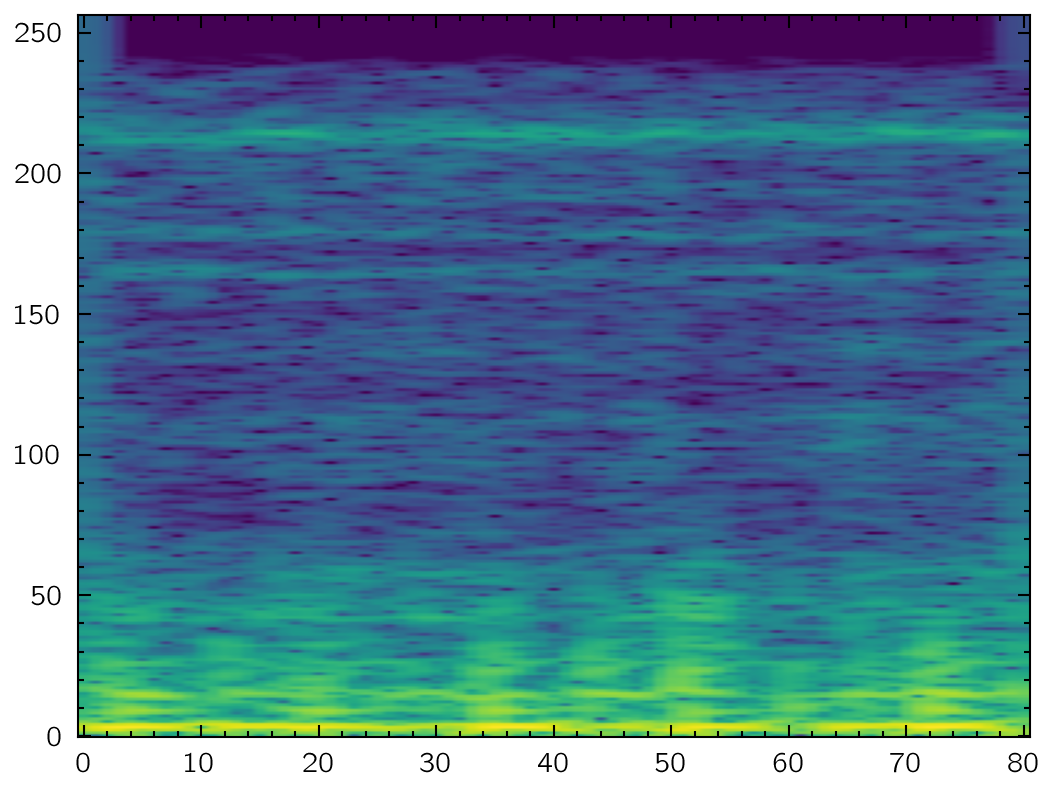

In [14]:
plt.imshow(spec_vib_x,aspect='auto',origin='lower')

## Construct intermediate dataframe

In [85]:
spec_narrow.shape

(257, 626)

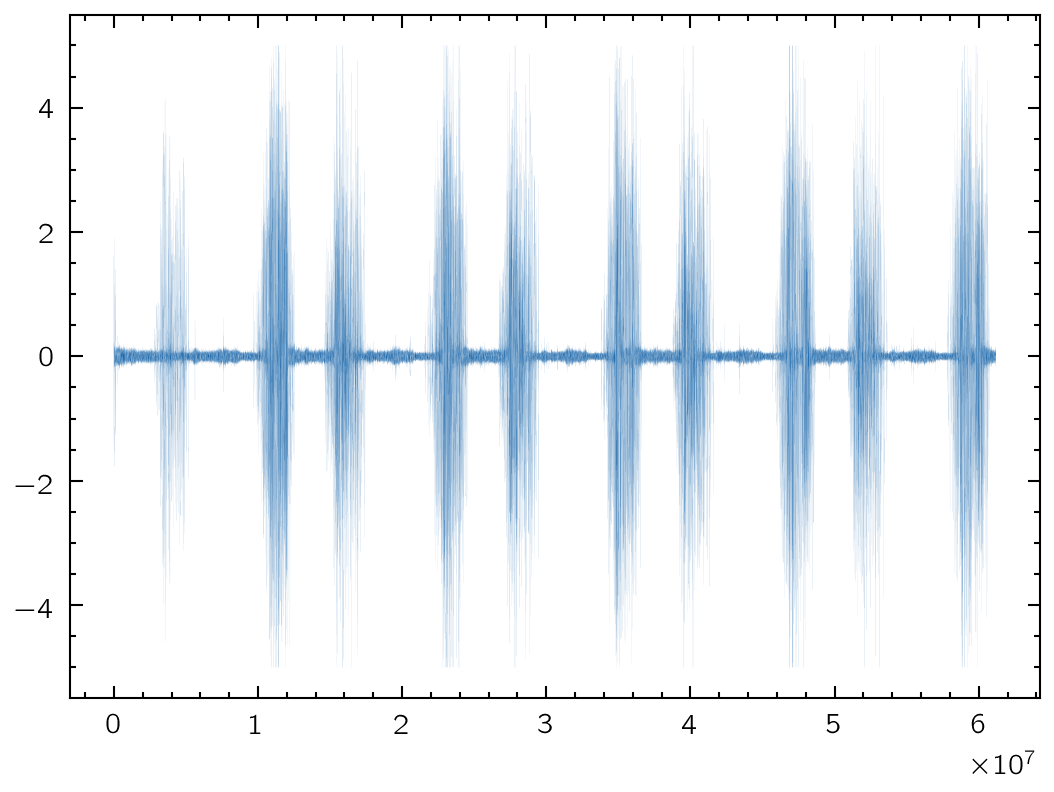

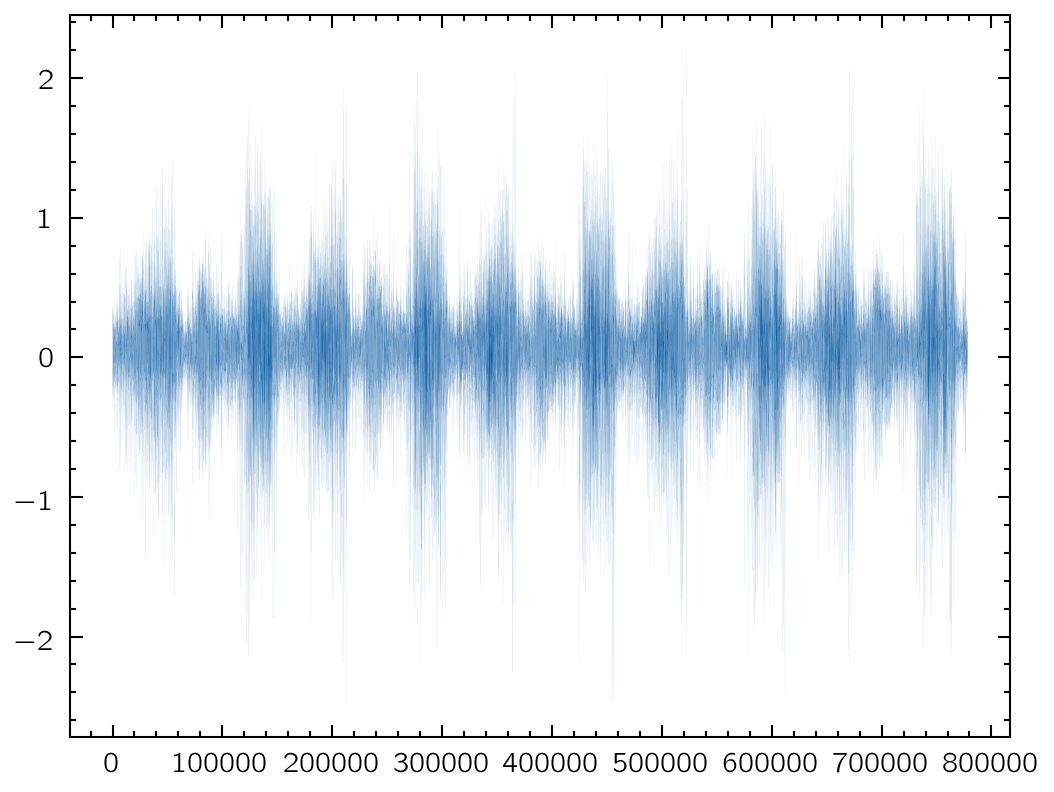

In [36]:
plt.plot(ae_df[0],lw=0.01)
plt.show()
plt.plot(vib_x,lw=0.01)
plt.show()